# MORDM
# 1st-round: 2-objectives

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import (perform_experiments, optimize, 
                                                   BaseEvaluator)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
# set random seed for reproducibility of the script

import numpy.random
import random

SEED = 42
numpy.random.seed(SEED)
random.seed(SEED)

## 0. Problem formulation

In [3]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(0) # assign problem_formulation_id

## 1st Iteration

We start the 1st iteration of MORDM from searching over the levers space under an arbitary scanerio fo the 2-objective PF.

### 1.1 Searching for candidate solutions

In [5]:
for unc in dike_model.uncertainties:
    print(repr(unc))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# assign values for uncertainties
ref_params = {'discount rate' : 1,
              'ID flood wave shape' : 132/2,
              'Bmax' : (30+350)/2,
              'pfail' : 0.5,
              'Brate' : 1}

ref_scenario = {}
for key in dike_model.uncertainties:
    if 'discount rate' in key.name:
        ref_scenario.update({key.name : ref_params['discount rate']})
    else:
        _, s = key.name.split('_')
        ref_scenario.update({key.name : ref_params[s]})
        
ref_scenario = Scenario('ref_scenario', **ref_scenario)

In [9]:
# check the uncertainties in ref_scenario
print(repr(ref_scenario))

Scenario({'discount rate 0': 1, 'discount rate 1': 1, 'discount rate 2': 1, 'A.0_ID flood wave shape': 66.0, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.5, 'A.1_Brate': 1, 'A.2_Bmax': 190.0, 'A.2_pfail': 0.5, 'A.2_Brate': 1, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.5, 'A.3_Brate': 1, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5, 'A.4_Brate': 1, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.5, 'A.5_Brate': 1})


In [20]:
n_scenarios = 8000

''' assign epsilon & max HyperVolume for the outcomes
# All Costs : 5e8 / 5e9
# Expected Number of Deaths : 1 / 10
'''
# : All Costs & Expected Number of Deaths
EPSILON_COSTS = 5e8
EPSILON_DEATHS = 1

epsilon = [EPSILON_COSTS, EPSILON_DEATHS] # epsilon for all timesteps

convergence_metrics = [HyperVolume(minimum=np.zeros(len(epsilon)), 
                                   maximum=epsilon*10),
                       EpsilonProgress()]

In [21]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=n_scenarios, 
                                 searchover='levers',
                                 epsilons=epsilon,
                                 convergence=convergence_metrics,
                                 reference=ref_scenario)

save_results(results, './results/mordm_8000runs_i1_2obj.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/8000 nfe
[MainProcess/INFO] generation 5: 497/8000 nfe
[MainProcess/INFO] generation 10: 997/8000 nfe
[MainProcess/INFO] generation 15: 1497/8000 nfe
[MainProcess/INFO] generation 20: 1994/8000 nfe
[MainProcess/INFO] generation 25: 2493/8000 nfe
[MainProcess/INFO] generation 30: 2990/8000 nfe
[MainProcess/INFO] generation 35: 3484/8000 nfe
[MainProcess/INFO] generation 40: 3961/8000 nfe
[MainProcess/INFO] generation 45: 4406/8000 nfe
[MainProcess/INFO] generation 50: 4815/8000 nfe
[MainProcess/INFO] generation 55: 5217/8000 nfe
[MainProcess/INFO] generation 60: 5584/8000 nfe
[MainProcess/INFO] generation 65: 5981/8000 nfe
[MainProcess/INFO] generation 70: 6389/8000 nfe
[MainProcess/INFO] generation 75: 6812/8000 nfe
[MainProcess/INFO] generation 80: 7227/8000 nfe
[MainProcess/INFO] generation 85: 7656/8000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/I

Wall time: 1h 5min 19s


In [4]:
results = load_results('./results/mordm_8000runs_i1_2obj.tar.gz')

solutions, convergence = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\mordm_8000runs_i1_2obj.tar.gz


#### *Check convergence*

Text(0.5, 0, 'number of function evaluations')

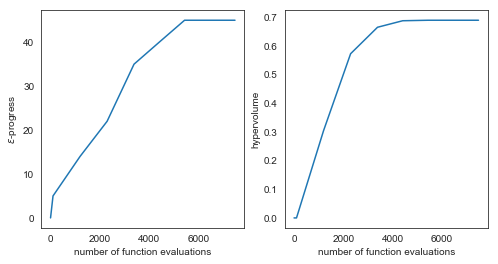

In [5]:
# check convergence metrics
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

#### *Check solution(s)*

In [6]:
# outcomes
solutions.loc[:, [o.name for o in dike_model.outcomes]]

,All Costs,Expected Number of Deaths
0,1.548910e+08,0.000983


In [7]:
# levers
solutions.loc[:, [l.name for l in dike_model.levers]]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0


In [8]:
# make Policy object
policy = solutions.loc[:, [l.name for l in dike_model.levers]].iloc[0].to_dict()
policy_to_evaluate = Policy('optimized_policy', **policy)
policy_to_evaluate

Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 2, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 4, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 3, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 4, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0})

### 1.2 Re-evaluate candidate solutions under uncertainty

In [15]:
n_scenarios = 8000

In [16]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,
                                            policies=policy_to_evaluate,
                                            uncertainty_sampling='mc')

save_results(results, './results/mordm_8000runs_i1_re-evaluation_mc.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 8000 scenarios * 1 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\mordm_8000runs_i1_re-evaluation_mc.tar.gz


Wall time: 1h 10min 41s


In [18]:
results = load_results('./results/mordm_8000runs_i1_re-evaluation_mc.tar.gz')

experiments, outcomes = results
experiments.drop(columns = [l.name for l in dike_model.levers], inplace=True) # drop levers

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\mordm_8000runs_i1_re-evaluation_mc.tar.gz


[MainProcess/INFO] no time dimension found in results


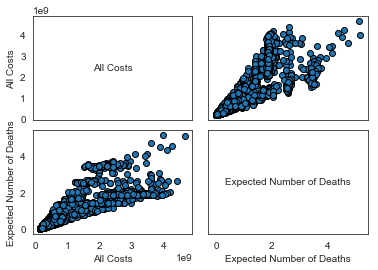

In [19]:
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, legend=False)

In [45]:
x = experiments
y = outcomes['Expected Number of Deaths'] < 1
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 8000 points remaining, containing 6511 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.69825, coverage: 0.8579327292274612, density: 1.0 restricted_dimensions: 3


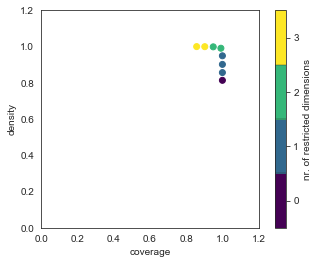

In [46]:
box1.show_tradeoff()
plt.show()

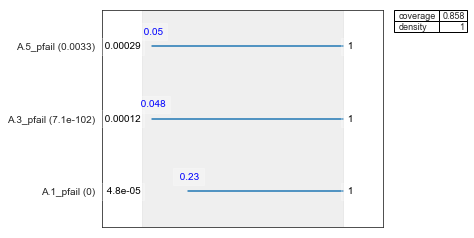

In [47]:
box1.inspect(style='graph')
plt.show()

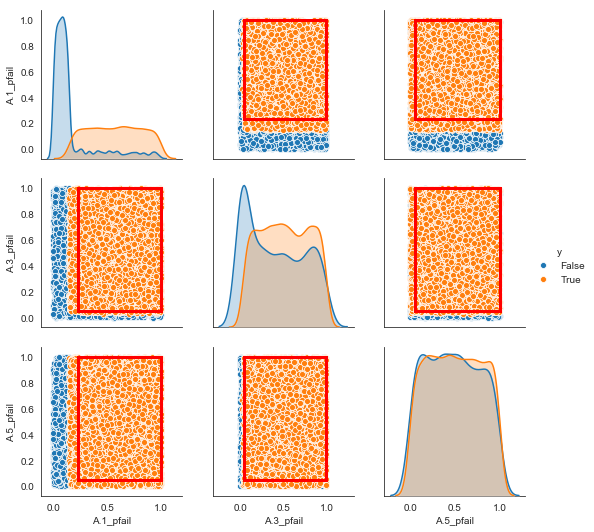

In [48]:
box1.show_pairs_scatter()
plt.show()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


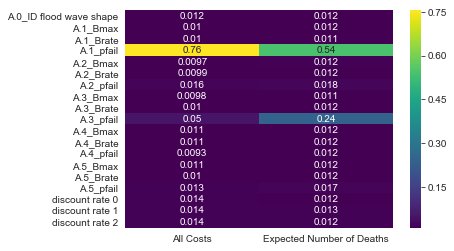

In [30]:
fs = feature_scoring.get_feature_scores_all(experiments, outcomes)
sns.heatmap(fs, cmap='viridis', annot=True)

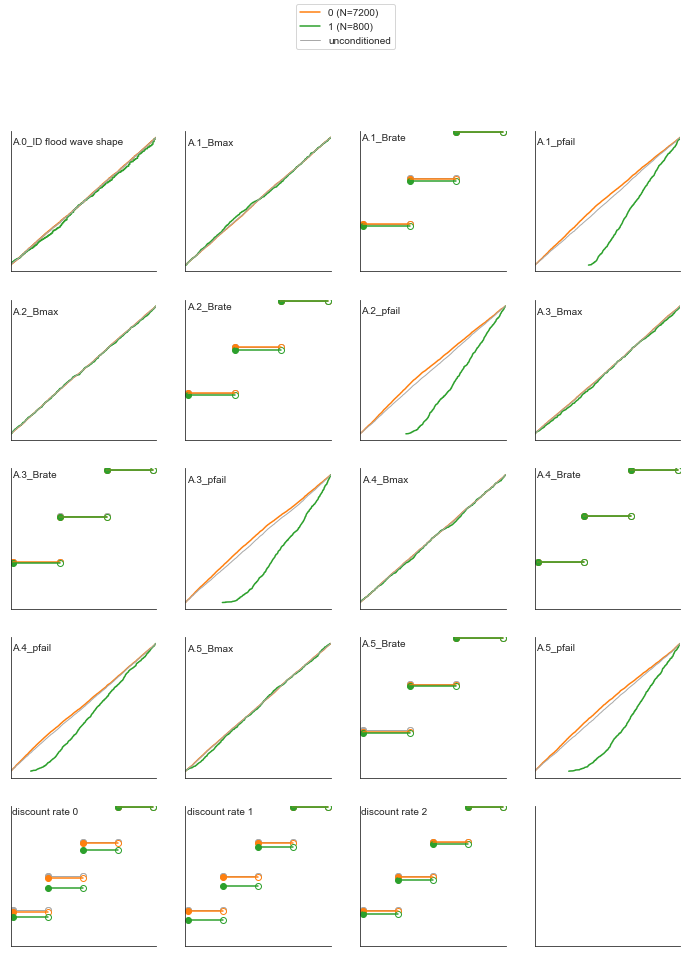

In [35]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

x = experiments.copy()
x = x.drop(['policy', 'model'], axis=1)
y = outcomes['All Costs'] < np.percentile(outcomes['All Costs'], q=10)
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

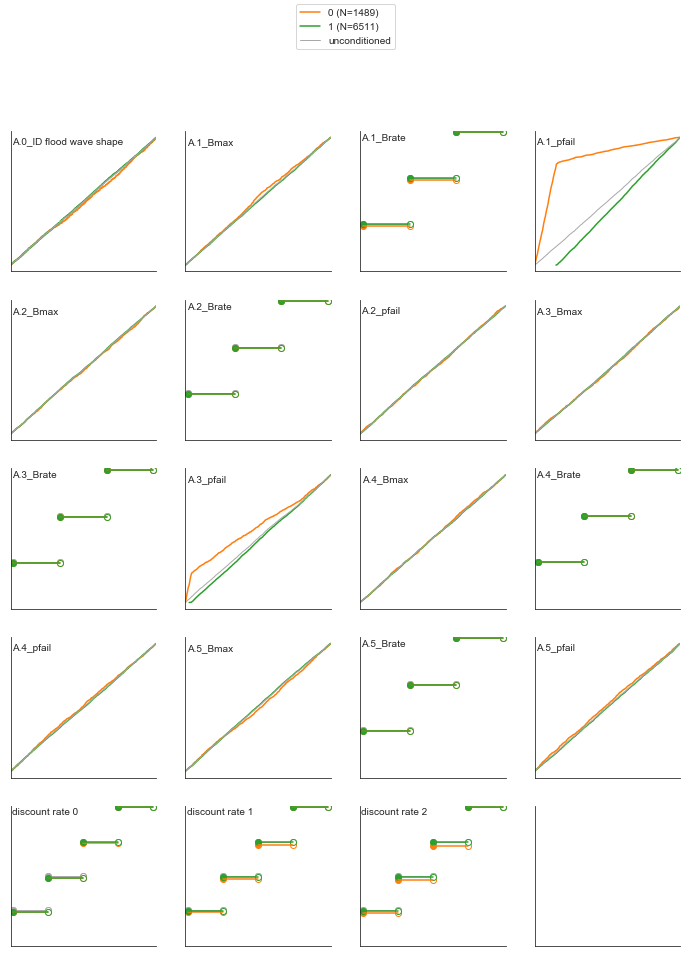

In [36]:
x = experiments.copy()
x = x.drop(['policy', 'model'], axis=1)
y = outcomes['Expected Number of Deaths'] < 1
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()